![alt text](https://esap.seas.upenn.edu/wp-content/themes/summer_engineering/media/seas_logo.png)

#Introduction

Welcome to our course project for CIS-5450 (Big Data Analytics)!

Our team consists of:

*   Ryan Abbate (MSE-DS, inaugural cohort)
*   Paul Hamel (MCIT, Spring 2022 cohort)
*   Milan Mistry (MCIT, Fall 2021 cohort)

<br>
For this project, we built machine learning models that predict a borrower's propensity to default on a loan. Throughout this notebook, we walk through our end-to-end process, which included:

* data ingestion
* exploratory data analysis (EDA)
* data wrangling
* data cleaning
* machine learning modeling
* data visualization


# Motivation

Individuals with insufficient or non-existent credit histories often encounter challenges in securing loans.  Those fortunate enough to obtain loans may fall victim to unscrupulous lenders who impose exorbitant interest rates and unfavorable lending terms.

Lenders generally aim to optimize profits while minimizing potential risks.  Lenders that use *accurate* predictive models when assessing default risk among certain customer profiles are able to extend credit to borrowers who may not meet traditional lending standards.  This data-driven approach ensures that borrowers who are capable of loan repayment receive the capital that they need, which has a stimulative effect on economic activity.


# Data Source

For this project, we used loan repayment data from a Kaggle competition hosted by [Home Credit Group](https://www.homecredit.net/) in 2018.  Details about the competition may be found [here](https://www.kaggle.com/competitions/home-credit-default-risk/overview).  The data consists of nine (9) csv files totaling approximately 3GB in size.  

# Data Ingestion

To retrieve and ingest the data from Kaggle's public API, users must authenticate with an API token.  To create an API token, please follow the instructions outlined [here](https://www.kaggle.com/competitions/home-credit-default-risk/overview).  The API token will be in the form of a JSON file named `kaggle.json`.  

#Dependencies

Let's begin by installing the required dependencies.


In [ ]:
# install dependencies with silenced output
!pip install kaggle --quiet
!pip install tqdm --quiet

Next, we import the Python libraries that we'll use for this project.

In [ ]:
# import the required libraries

# general
from google.colab import drive
from tqdm.notebook import tqdm
import os


# data wrangling, cleaning and sampling
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
import numpy as np
import pandas as pd

# preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

# model selection
from sklearn.model_selection import train_test_split

# models
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge

from sklearn.neighbors import KNeighborsClassifier

from sklearn.svm import SVC

from sklearn.tree import DecisionTreeClassifier

from xgboost.sklearn import XGBClassifier

# model tuning
from sklearn.model_selection import GridSearchCV

# metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# visualization
from matplotlib import colors
from matplotlib import lines
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.ticker as mtick
import seaborn as sns


In [ ]:
# Graph Settings

mpl.rcParams['figure.figsize'] = [12,6]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlepad'] = 25
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.labelweight'] = 'normal'
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['text.usetex'] = False
mpl.rcParams['figure.titleweight'] = 'normal'
mpl.rcParams['font.family'] = 'Sans'
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['font.size'] = 12
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.left'] = True
mpl.rcParams['axes.spines.right'] = 0
mpl.rcParams['ytick.labelleft'] = True
mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.color'] = 'lightgrey'
mpl.rcParams['xtick.color'] = 'lightgrey'
mpl.rcParams['text.color'] = 'lightgrey'
mpl.rcParams['axes.titlecolor'] = 'lightgrey'
mpl.rcParams['axes.labelcolor'] = 'lightgrey'
mpl.rcParams['axes.edgecolor'] = 'lightgrey'

mpl.rcParams['date.autoformatter.year'] = '%Y'
mpl.rcParams['date.autoformatter.month'] = '%b-%Y'
#change background color to transparent
mpl.rcParams['figure.facecolor'] = '#282c34'
#change plot foreground color to grey
mpl.rcParams['axes.facecolor'] = '#282c34'

#mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=["#00396f", "#a12830", '#00ab39',"#ffe312",'#c41e98','#008000','#ff5e00','#00a6d4','#6c1b72'])
#change default color cycler to ggplot
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#57D7BA','#f78948','#87CEFA','#B18FCF','#fe5555','#2F3F4D'])
mpl.rcParams['lines.linewidth'] = 2
colors = ['#57D7BA','#f78948','#87CEFA','#B18FCF','#fe5555','#2F3F4D']
#colors = ["#00396f", "#a12830", '#00ab39',"#ffe312",'#c41e98','#008000','#ff5e00','#00a6d4','#6c1b72']

Run the cell below, then click "Choose Files".  Browse to the `kaggle.json` file, then select this file for upload.

In [ ]:
# # upload your Kaggle API key to download the data
# from google.colab import files
# files.upload()


Next, we'll create a Kaggle directory and copy the file containing our API token into the newly created directory.

In [ ]:
# # create the Kaggle directory
# !mkdir ~/.kaggle

# # copy the file containing API key to newly created directory and change file permissions
# !cp /content/kaggle.json ~/.kaggle/
# !chmod 600 /root/.kaggle/kaggle.json

We'll now download the dataset in the form of a zip file.

In [ ]:
# # download the dataset
# !!kaggle competitions download -c home-credit-default-risk

After downloading the dataset, we'll unzip the file into our `Content` directory.

In [ ]:
# # unzip the zip file into the Content directory
# !unzip /content/home-credit-default-risk.zip

Now, we'll identify the files that we'll use during our analysis and exclude those that are irrelevant.

In [ ]:
# the list of files to exclude from relevant data files
excluded_files = ['kaggle.json', 'home-credit-default-risk.zip', '.config', 'sample_data', 'sample_submission.csv', 'HomeCredit_columns_description.csv']

# create a list of relevant data files
data_files = [data_file for data_file in os.listdir('/content') if data_file not in excluded_files]
data_files


After identifying the relevant eight (8) data files, we'll create a Pandas dataframe for each.  Notice that we create an empty dictionary `d`, then iterate through the list of relevant file and append `_df` to the file name when assigning the name of the dataframe.  We use the popular `tqdm` library to monitor progress as the dataframes are being created.

In [ ]:
# iterate over list of relevant data files and create a Pandas dataframe for each

d = {}

for data_file in tqdm(data_files):
  # if 'bureau' in data_file:
  #   continue
  print('Creating:', data_file.removesuffix('.csv') + '_df')
  d[(data_file.removesuffix('.csv') + '_df').lower()] = pd.read_csv(data_file)


In [ ]:
# # #For Paul when running locally -- ignore this
d = {}
d['application_test_df'] = pd.read_csv('./data/application_test.csv', encoding='latin-1')
d['application_train_df'] = pd.read_csv('./data/application_train.csv', encoding='latin-1')
# d['bureau_df'] = pd.read_csv('./data/bureau.csv', encoding='latin-1')
# d['bureau_balance_df'] = pd.read_csv('./data/bureau_balance.csv', encoding='latin-1')
d['credit_card_balance_df'] = pd.read_csv('./data/credit_card_balance.csv', encoding='latin-1')
d['installments_payments_df'] = pd.read_csv('./data/installments_payments.csv', encoding='latin-1')
d['pos_cash_balance_df'] = pd.read_csv('./data/POS_CASH_balance.csv', encoding='latin-1')
d['previous_application_df'] = pd.read_csv('./data/previous_application.csv', encoding='latin-1')

Since we stored the dataframes in a dictionary `d`, we access a given dataframe by its key.  Let's inspect the data.

In [ ]:
# access dataframes via a dictionary such as d['application_train_df']
d['application_train_df'].head(3)

In [ ]:
# inspect all dataframes
for key, df in d.items():
  print(key)
  print('\n')
  print(df.head())
  print('\n')


In [ ]:
# cast all column headers to lowercase
for key, df in d.items():
  df.columns = df.columns.str.lower()


#Exploratory Data Analysis (EDA)

We start by exploring the basic characteristics of the various datasets.  For each dataframe, we call the `info()` method to display the data type and non-null counts.  We also call the `describe()` method to display the summary statistics.

In [ ]:
for key, df in d.items():
  print(key)
  df.info(verbose = True, show_counts = True)
  print('-' * 72)

For each dataframe, let's check the percent of missing values for each attribute.

In [ ]:
for key, df in d.items():
  print(key)
  percent_missing = df.isnull().sum() * 100 / len(df)
  missing_values_df = pd.DataFrame({'column_name': df.columns,
                                    'percent_missing': percent_missing}) \
                                .sort_values(by = ['percent_missing'], ascending = False).round(2)
  print(missing_values_df)
  print('-' * 72)




We immediately notice that there is a **large** amount of missing data.

We notice the prevalance of the `sk_id_curr` attribute, which is the primary key of the `application_{test | train}_df` relations.  The following relations have `sk_id_curr` as a foreign key:

*   `bureau_df`
*   `pos_cash_balance_df`
*   `previous_application_df`
*   `installments_payments_df`
*   `credit_card_balance_df`

We will join the `application_{test | train}_df` relations to each of the five (5) above-mentioned relations.

We also notice the prevalance of the `sk_id_prev` attribute, which is the primary key of the `previous_application_df` relation.  The following relations have `sk_id_prev` as a foreign key:

*   `pos_cash_balance_df`
*   `installments_payments_df`
*   `credit_card_balance_df`

Lastly, we notice that the `sk_id_bureau` attribute is the primary key of the `bureau_df` relation.  The `bureau_balance_df` relation has `sk_id_bureau` as a foreign key.  We will therefore join these two relations together.


First, we explore what % of the unique `sk_id_prev` IDs are within each dataset. We see that most of the datasets have a high representation of the IDs present. The two datasets with low representation are the `bureau_balance_df` and the `credit_card_balance_df` dataframes. We will later explore whether adding features from these two datasets are better when having a dummy variable for whether each feature is valid, or whether multiple models depending on the availability of data is more suitable for this dataset.

In [ ]:
train_ids = d['application_train_df']['sk_id_curr'].unique()

# Bureau
# bureau_pct = len(np.intersect1d(d['bureau_df']['sk_id_curr'].unique(), train_ids)) / len(train_ids)
# print('Bureau: {:.2%}'.format(bureau_pct))

# # Bureau Balance
# valid_bureau_ids = np.intersect1d(d['bureau_balance_df']['sk_id_bureau'].unique(), d['bureau_df']['sk_id_bureau'].unique())
# buearu_balance_pct = len(np.intersect1d(d['bureau_df'].loc[d['bureau_df']['sk_id_bureau'].isin(valid_bureau_ids),'sk_id_curr'].unique(),train_ids)) / len(train_ids)
# print('Bureau Balance: {:.2%}'.format(buearu_balance_pct))

# Credit Card Balance
cc_pct = len(np.intersect1d(d['credit_card_balance_df']['sk_id_curr'].unique(), train_ids)) / len(train_ids)
print('Credit Card Balance: {:.2%}'.format(cc_pct))

# Previous Application
prev_app_pct = len(np.intersect1d(d['previous_application_df']['sk_id_curr'].unique(),train_ids)) / len(train_ids)
print('Previous Application: {:.2%}'.format(prev_app_pct))

# POS Cash Balance
pos_cash_pct = len(np.intersect1d(d['pos_cash_balance_df']['sk_id_curr'].unique(),train_ids)) / len(train_ids)
print('POS Cash Balance: {:.2%}'.format(pos_cash_pct))

# Installments Payments
installments_pct = len(np.intersect1d(d['installments_payments_df']['sk_id_curr'].unique(),train_ids)) / len(train_ids)
print('Installments Payments: {:.2%}'.format(installments_pct))


Let's check for duplication.

In [ ]:
for key, df in d.items():
  print('Dataframe:', key)
  print(df.nunique())
  print('-' * 72)

In [ ]:
# get summary statistics of each dataset

for key, df in d.items():
  print(key)
  print(df.describe(include = np.number).T)
  print('-' * 72)

In [235]:
#freeing memory
df.drop(df.index,inplace=True)

## Distrubtion of Response Variable

- The training data consists primarily of loans that have not defaulted.  Therefore, in a later step, we must oversample or undersample to compensate for this unbalanced data.

In [ ]:
# plot the distribution of the Response Variable in the training dataset
# will need to do some form of undersampling or oversampling to deal with the class imbalance

ax = (d['application_train_df']['target'].value_counts() * 100/len(d['application_train_df'])).plot(kind = 'bar')

plt.title('Distribution of Target Variable in Training Dataset')
plt.xlabel('Default Indicator')
plt.ylabel('Percent of Total')
plt.xticks(rotation = 'horizontal')

ax.bar_label(ax.containers[0], label_type = 'edge', fmt = '%.1f%%')
ax.margins(y = 0.1)

#make y axis percentages
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.show()

The training dataset has highly unbalanced classes, which could affect our modeling.

#Correlation Analysis
Now, we'll generate a correlation matrix on the training dataset to check for correlation among the features.

In [ ]:
pd.options.display.max_columns = 200
pd.options.display.max_rows = 200

corr = d['application_train_df'].corr(numeric_only = True)
corr.style.background_gradient(cmap = 'coolwarm').format(precision = 2)


Given the size of this correlation matrix, let's set a threshold and view only the features that have correlation greater than a certain threshold.

In [ ]:
# define a threshold
correlation_threshold = 0.7

# get a list of pair-wise features that exceed this threshold
high_correlation_pairs = []
for i in range(len(corr.columns)):
    for j in range(i + 1, len(corr.columns)):
        if abs(corr.iloc[i, j]) > correlation_threshold:
            high_correlation_pairs.append((corr.columns[i], corr.columns[j]))


high_correlation_pairs


In [ ]:
print(f'There are {len(high_correlation_pairs)} that exhibit correlation greater than {correlation_threshold}.')

In [ ]:
# create a heatmap of only the high correlation pairs

high_correlation_features = set()

for pair in high_correlation_pairs:
  high_correlation_features.update(pair)

high_correlation_matrix = corr.loc[high_correlation_features, high_correlation_features]
high_correlation_matrix

high_correlation_matrix.style.background_gradient(cmap = 'coolwarm').format(precision = 2)



In [ ]:
#pd.options.display.max_rows = 100

## Housing Variables

Many of the highly correlated features are housing variables that have characteristics of their current living situation (characteristics regarding their home or apartment). We will reduce the dimensionality of these features by creating PCA variables on these `housing variables` so that we may use them in our modeling. We will then fit a simple logistic regression to see if there is any predictability of using these outright to see if these variables have any predictability on their own.

Due to the high prevalence of null values in these, we fit the PCA and explore the model with the rows that have no nulls in any of them (~25%), and then fill all missing values with the mean of that respective column before transforming the variables of the main dataframes (train/test).

In [ ]:
housing_variables = [ 'apartments_avg',
                      'basementarea_avg',
                      'years_beginexpluatation_avg',
                      'years_build_avg',
                      'commonarea_avg',
                      'elevators_avg',
                      'entrances_avg',
                      'floorsmax_avg',
                      'floorsmin_avg',
                      'landarea_avg',
                      'livingapartments_avg',
                      'livingarea_avg',
                      'nonlivingapartments_avg',
                      'nonlivingarea_avg',
                      'apartments_mode',
                      'basementarea_mode',
                      'years_beginexpluatation_mode',
                      'years_build_mode',
                      'commonarea_mode',
                      'elevators_mode',
                      'entrances_mode',
                      'floorsmax_mode',
                      'floorsmin_mode',
                      'landarea_mode',
                      'livingapartments_mode',
                      'livingarea_mode',
                      'nonlivingapartments_mode',
                      'nonlivingarea_mode',
                      'apartments_medi',
                      'basementarea_medi',
                      'years_beginexpluatation_medi',
                      'years_build_medi',
                      'commonarea_medi',
                      'elevators_medi',
                      'entrances_medi',
                      'floorsmax_medi',
                      'floorsmin_medi',
                      'landarea_medi',
                      'livingapartments_medi',
                      'livingarea_medi',
                      'nonlivingapartments_medi',
                      'nonlivingarea_medi',
                      'housetype_mode',
                      'totalarea_mode',
                      'wallsmaterial_mode',
                      'emergencystate_mode'
                    ]

In [ ]:
print("Percent of rows with valid data for all housing variables: {:.2%}".format((d['application_train_df'][housing_variables].isna().sum(axis = 1) == 0).astype(int).sum() / len(d['application_train_df'])))


Due to the lack of variability for the `emergencystate_mode` and `housetype_mode` features, we will drop them from the dataset.

In [ ]:
d['application_train_df']['housetype_mode'].value_counts()

In [ ]:
d['application_train_df']['emergencystate_mode'].value_counts()

In [ ]:

housing_variables.remove('housetype_mode')
housing_variables.remove('emergencystate_mode')

d['application_train_df'].drop(columns = ['housetype_mode','emergencystate_mode'],inplace=True)
d['application_test_df'].drop(columns = ['housetype_mode','emergencystate_mode'],inplace=True)

There are only 2 prevalent `wallsmaterial_mode` values, but they have some differentiation in default rates, so we will retain this feature. We will one-hot encode this feature and consider converting all values that are not "Panel" or "Stone, brick" as "Others". All null values for this attribute will be populated as "Others"

In [ ]:
d['application_train_df'].groupby('wallsmaterial_mode').agg({'target':'mean','sk_id_curr':'count'}).sort_values(by='target').reset_index()


In [ ]:
#There are only 27 rows that have valid data for all housing variables (except wallsmaterial_mode),
#so fitting the PCA while one-hot encoding the `wallsmaterial_mode` variable will not be feasible.

d['application_train_df'].dropna(subset = [x for x in housing_variables if x != 'wallsmaterial_mode'])['wallsmaterial_mode'].isna().sum()


In [ ]:
d['application_train_df'].loc[~d['application_train_df']['wallsmaterial_mode'].isin(['Panel','Stone, brick']),'wallsmaterial_mode'] = 'Other'
d['application_test_df'].loc[~d['application_test_df']['wallsmaterial_mode'].isin(['Panel','Stone, brick']),'wallsmaterial_mode'] = 'Other'


In [ ]:
d['application_train_df'].groupby('wallsmaterial_mode').agg({'target':'mean','sk_id_curr':'count'}).sort_values(by='target')


In [ ]:
d['application_train_df'] = pd.get_dummies(d['application_train_df'], columns = ['wallsmaterial_mode'])
d['application_test_df'] = pd.get_dummies(d['application_test_df'], columns = ['wallsmaterial_mode'])

wall_material_cols = [x for x in d['application_train_df'].columns if 'wallsmaterial_mode_' in x]

d['application_train_df'][wall_material_cols] = d['application_train_df'][wall_material_cols].astype(int)
d['application_test_df'][wall_material_cols] = d['application_test_df'][wall_material_cols].astype(int)

#remove trhe wallsmaterial_mode column from the housing variables list and append the new one-hot `encodedwallsmaterial_mode` columns
housing_variables.remove('wallsmaterial_mode')
housing_variables.extend(wall_material_cols)


In [ ]:
#getting a subset with only the rows that have valid data for all housing variables
app_train_housing = d['application_train_df'].dropna(subset=housing_variables).copy()


In [ ]:
app_train_housing[housing_variables] = StandardScaler().fit_transform(app_train_housing[housing_variables])
pca = PCA(n_components = len(housing_variables))
pca.fit(app_train_housing[housing_variables])
explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = explained_variance_ratios.cumsum()

In [ ]:
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

ax.plot(cum_evr)
ax.set_xticks(np.arange(0, len(housing_variables), 5))
ax.set_xticklabels(np.arange(0, len(housing_variables), 5) + 1, rotation = 0)

ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('Cumulative Explained Ratio')
ax.set_title('Cumulative Explained Ratio by Number of Principal Components')

#Vertical Line here at 11 really means 12 components
ax.axvline(11, linestyle = '--', color='green')

plt.show()

In [ ]:
"{:.2%}".format(cum_evr[11]) #note that 11 is the 12th component

A PCA with **12 principal components** allows us to capture 95% of the variability within the housing variables.

In [ ]:
pca = PCA(n_components = 12)
pca.fit(app_train_housing[housing_variables])

In [ ]:
app_train_housing = pd.concat([app_train_housing,pd.DataFrame(pca.transform(app_train_housing[housing_variables]), columns = ['housing_pca_' + str(x) for x in range(1,13)],index = app_train_housing.index)],axis = 1)


In [ ]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(app_train_housing[['housing_pca_' + str(x) for x in range(1,13)]],app_train_housing['target'], test_size = 0.3, random_state = seed)


In [ ]:
#Note that we must oversample or undersample to account for the imbalance in the target variable. We will use oversampling here.
d['application_train_df'].target.value_counts()


In [ ]:
X_train_resampled, y_train_resampled = RandomOverSampler(random_state=seed).fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = RandomOverSampler(random_state=seed).fit_resample(X_test, y_test)


In [ ]:
clf = LogisticRegression(random_state=42,max_iter = 100).fit(X_train_resampled, y_train_resampled)


# Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = clf.predict(X_test_resampled)

#Find the accuracy and store the value in `log_acc`
log_acc = (y_pred == y_test_resampled).sum() / len(y_test_resampled)
print("{:.2%}".format(log_acc))

While not a huge boost to predictability, with solely the housing PCA components, we see a 53.6% accuracy score, thus we will keep these features and our model may or may not select them in the future. We will fill in the missing values and perform the modeling again to ensure we get consistent results after filling in nulls values. Many rows have some of the housing variables, with some (or many) being null

In [ ]:
for col in housing_variables:
    d['application_train_df'][col].fillna(d['application_train_df'][col].mean(),inplace=True)
    d['application_test_df'][col].fillna(d['application_test_df'][col].mean(),inplace=True)


In [ ]:
#PCA on train and test after filling nulls. Using the PCA fit on the subset that had no null values
d['application_train_df'] = pd.concat([d['application_train_df'],pd.DataFrame(pca.transform(d['application_train_df'][housing_variables]), columns = ['housing_pca_' + str(x) for x in range(1,13)],index = d['application_train_df'].index)],axis = 1)
d['application_test_df'] = pd.concat([d['application_test_df'],pd.DataFrame(pca.transform(d['application_test_df'][housing_variables]), columns = ['housing_pca_' + str(x) for x in range(1,13)],index = d['application_test_df'].index)],axis = 1)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(d['application_train_df'][['housing_pca_' + str(x) for x in range(1,13)]],d['application_train_df']['target'], test_size = 0.3, random_state = seed)
X_train_resampled, y_train_resampled = RandomOverSampler(random_state=seed).fit_resample(X_train, y_train)
X_test_resampled, y_test_resampled = RandomOverSampler(random_state=seed).fit_resample(X_test, y_test)


In [ ]:
clf = LogisticRegression(random_state=42,max_iter = 100).fit(X_train_resampled, y_train_resampled)


# Use the model to predict on the test set and save these predictions as `y_pred`
y_pred = clf.predict(X_test_resampled)

#Find the accuracy and store the value in `log_acc`
log_acc = (y_pred == y_test_resampled).sum() / len(y_test_resampled)
print("{:.2%}".format(log_acc))


The predictability remained consistent after populating the `null` values with the mean.

In [ ]:
#Drop the housing variables that are not the PCA components
d['application_train_df'].drop(columns = housing_variables,inplace=True)
d['application_test_df'].drop(columns = housing_variables,inplace=True)


Let's look at a pairplot.

In [ ]:
#
#df = d['application_train_df']
#df = df[list(high_correlation_features)]
#df.head()

In [ ]:
#sns.pairplot(data = df)

Now, let's plot the distribution of the categorical variables using `sns.countplot()`.

In [ ]:
# gets the columns that have categorical variables

object_columns = d['application_train_df'].select_dtypes(include=['object']).columns.tolist()
object_columns


In [ ]:
# plot the categorical variables

# define height ratios for the subplots
height_ratios = [50] * 7 + [50]

# create an 8x2 subplot grid
fig, axes = plt.subplots(8, 2, figsize=(16, 40), gridspec_kw={'height_ratios': height_ratios})

plt.subplots_adjust(hspace = 1.5)

# flatten the axes array for easy iteration
axes = axes.flatten()

for i, column in enumerate(object_columns):
    sns.countplot(x = column, data = d['application_train_df'], ax = axes[i])
    axes[i].set_title(column)
    axes[i].tick_params(axis='x', rotation=45)

#plt.tight_layout(h_pad = 2.5)
plt.show()

In [ ]:
# initial impressions
# predominent:  married females with a secondary education who own a home (but don't own a car) applying for cash loans

In [ ]:
# Does a large amount of credit result in a default condition?  No!

sns.boxplot(data = d['application_train_df'], x = 'target', y = 'amt_credit')
plt.grid()
plt.show()

In [ ]:
# Is there a greater incidence of default among male borrowers?  Yes! (about 300 basis points greater than for female borrowers)

gender_target_counts = d['application_train_df'].groupby(['code_gender', 'target']).size()

gender_target_counts_unstacked = gender_target_counts.unstack('target')

percentage_defaults_by_gender = gender_target_counts_unstacked.div(gender_target_counts_unstacked.sum(axis = 1), axis = 0) * 100

print(percentage_defaults_by_gender)

#Changing gender to a binary variable with 1 = Female, 0 Otherwise
d['application_train_df']['code_gender']  = np.where(d['application_train_df']['code_gender'] == 'F',1,0)
d['application_test_df']['code_gender']  = np.where(d['application_test_df']['code_gender'] == 'F',1,0)

In [ ]:
# Do borrowers who own a realty default more than borrowers who do not?  Approximately equal, but home owners are slightly less likely to default.

own_realty_target_counts = d['application_train_df'].groupby(['flag_own_realty', 'target']).size()

own_realty_target_counts_unstacked = own_realty_target_counts.unstack('target')

percentage_defaults_by_gender = own_realty_target_counts_unstacked.div(own_realty_target_counts_unstacked.sum(axis = 1), axis = 0) * 100

print(percentage_defaults_by_gender)

d['application_train_df']['flag_own_realty']  = np.where(d['application_train_df']['flag_own_realty'] == 'Y',1,0)
d['application_test_df']['flag_own_realty']  = np.where(d['application_test_df']['flag_own_realty'] == 'Y',1,0)

In [ ]:
# Does the number of children impact default rates?  Approximately equal between 1-2 children, then seemingly impacted between 3-6 children. No children has the lowest default rate.

cnt_children_target_counts = d['application_train_df'].groupby(['cnt_children', 'target']).size()

cnt_children_target_counts_unstacked = cnt_children_target_counts.unstack('target')

percentage_defaults_by_gender = cnt_children_target_counts_unstacked.div(cnt_children_target_counts_unstacked.sum(axis = 1), axis = 0) * 100

print(percentage_defaults_by_gender)

#convert into 2 binary variables, one for having one child, one for having multiple children. People with multiple children will have a 1 in both columns
d['application_train_df']['has_child']  = np.where(d['application_train_df']['cnt_children'] > 0,1,0)
d['application_test_df']['has_child']  = np.where(d['application_test_df']['cnt_children'] > 0,1,0)

d['application_train_df']['has_multiple_children']  = np.where(d['application_train_df']['cnt_children'] > 1,1,0)
d['application_test_df']['has_multiple_children']  = np.where(d['application_test_df']['cnt_children'] > 1,1,0)

d['application_train_df'].drop('cnt_children',axis=1,inplace=True)
d['application_test_df'].drop('cnt_children',axis=1,inplace=True)

In [ ]:
# Do borrowers who own a car default more than those who do not?  Car owners are less likely to default

own_car_target_counts = d['application_train_df'].groupby(['flag_own_car', 'target']).size()

own_car_target_counts_unstacked = own_car_target_counts.unstack('target')

percentage_defaults_by_gender = own_car_target_counts_unstacked.div(own_car_target_counts_unstacked.sum(axis = 1), axis = 0) * 100

print(percentage_defaults_by_gender)

In [ ]:
# Age of Car -- is correlated with default, but with the range of values so it may be better to take the log of this value
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
temp = d['application_train_df'].groupby('own_car_age').agg({'target':['mean','count']})
temp = temp.loc[temp['target']['count'] > 100, 'target']['mean']
ax.scatter(temp.index, temp.values)

ax.set_ylim(0,0.25)
ax.set_xlim(0,40)

# TO DO:  add axes titles and plot title

In [ ]:
# Car age is correlated, so let's just take the log of it, adding 1 to avoid an -inf error

d['application_train_df']['own_car_age'] = np.log(d['application_train_df']['own_car_age'] + 1)
d['application_test_df']['own_car_age'] = np.log(d['application_test_df']['own_car_age'] + 1)
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
temp = d['application_train_df'].groupby('own_car_age').agg({'target':['mean','count']})
temp = temp.loc[temp['target']['count'] > 100, 'target']['mean']
ax.scatter(temp.index, temp.values)

ax.set_ylim(0,0.25)
ax.set_xlim(0,5)

# TO DO:  add axes titles and plot title

Virtually all values with a NULL `own_car_age` has a "N" for `flag_own_car`, thus we do not need another binary variable reprenting that `own_car_age` is NULL. We fill the null `own_car_age` with the mean

In [ ]:
d['application_train_df']['own_car_age'].mean()


In [ ]:
d['application_train_df'].loc[d['application_train_df']['own_car_age'].isna(),'target'].mean()


In [ ]:
d['application_train_df']['flag_own_car'].isna().sum()


In [ ]:
d['application_train_df'].loc[d['application_train_df']['own_car_age'].isna(),'flag_own_car'].value_counts()


In [ ]:
d['application_train_df']['own_car_age'].fillna(d['application_train_df']['own_car_age'].mean(),inplace=True)
d['application_test_df']['own_car_age'].fillna(d['application_test_df']['own_car_age'].mean(),inplace=True)


There does seem to be some correlation with hour of application, although this may be a fluke.
People who apply in the early-morning have the highest default rate, morning (pre-noon) ,followed by night and then day

In [ ]:

def hour_of_application(hour):
    if hour > 17 or hour < 4:
        return 'night'
    elif hour < 9:
        return 'early-morning'
    elif hour <= 12:
        return 'morning'
    else:
        return 'afternoon'

In [ ]:
d['application_train_df']['hour_appr_process_start'].apply(hour_of_application).value_counts()


In [ ]:
d['application_train_df']['hour_appr_process_start'] = d['application_train_df']['hour_appr_process_start'].apply(hour_of_application)
d['application_test_df']['hour_appr_process_start'] = d['application_test_df']['hour_appr_process_start'].apply(hour_of_application)


In [ ]:
#There may be a correlation with when people start their application
col = 'hour_appr_process_start'
fig = plt.figure(figsize = (12,6))
ax = fig.add_subplot(111)
ax.bar(x = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})['target'].index, height = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})['target'].values)

ax.set_ylim(0,0.1)

# # TO DO:  add axes titles and plot title

In [ ]:
# Values other than 'Working','Commercial associate','Pensioner','State servant' are extremely rare for the columns 'name_income_type' and will be grouped into an 'Other' category

print(d['application_train_df']['name_income_type'].value_counts())

d['application_train_df'].loc[~d['application_train_df']['name_income_type'].isin(['Working','Commercial associate','Pensioner','State servant']),'name_income_type'] = 'Other'
d['application_test_df'].loc[~d['application_test_df']['name_income_type'].isin(['Working','Commercial associate','Pensioner','State servant']),'name_income_type'] = 'Other'

In [ ]:
# majority of people are solo. Other then Family / spouse or partner, it's pretty sparse, so not worth one-hot encoding. Instead, we have a binary variable for "lives_alone"

print(d['application_train_df']['name_type_suite'].value_counts())

d['application_train_df']['lives_alone']  = np.where(d['application_train_df']['name_type_suite'] == 'Unaccompanied',1,0)
d['application_train_df'].drop('name_type_suite',axis=1,inplace=True)

d['application_test_df']['lives_alone']  = np.where(d['application_test_df']['name_type_suite'] == 'Unaccompanied',1,0)
d['application_test_df'].drop('name_type_suite',axis=1,inplace=True)

In [ ]:
print(d['application_train_df']['name_education_type'].value_counts())

#grouping in Academic Degree with Higher Education as it is a form of Higher Education and there are only 164 rows with Academic Degree
d['application_train_df'].loc[d['application_train_df']['name_education_type'] == 'Academic degree','name_education_type'] = 'Higher education'
d['application_test_df'].loc[d['application_test_df']['name_education_type'] == 'Academic degree','name_education_type'] = 'Higher education'

In [ ]:
#unknown is 2 samples. saving a column by just making it Single / not married

print(d['application_train_df']['name_family_status'].value_counts())
d['application_train_df'].loc[d['application_train_df']['name_family_status'] == 'Unknown','name_family_status'] = 'Single / not married'
d['application_test_df'].loc[d['application_test_df']['name_family_status'] == 'Unknown','name_family_status'] = 'Single / not married'

In [ ]:
#Why are House / apartment not seperated? -- Makes this feature essentially useless. Will keep this as is and will one-hot encode it

d['application_train_df']['name_housing_type'].value_counts()

In [ ]:
d['application_train_df'].groupby('name_housing_type').agg({'target':'mean','sk_id_curr':'count'}).sort_values(by='target').reset_index()


In [ ]:
d['application_test_df']['name_housing_type'].value_counts()


In [ ]:
d['application_train_df'][[x for x in d['application_train_df'].columns if 'amt_req_credit' in x]].isna().sum()


For the `amt_req_credit` columns, these represent how many credit pulls they've had during certain time periods. The null values have a higher default rate, so we will fill the nulls with a mean and have a dummy variable for `unknown_credit`

In [ ]:
for col in [x for x in d['application_train_df'].columns if 'amt_req_credit' in x]:
    print(col)
    print(d['application_train_df'][col].value_counts())

In [ ]:
d['application_train_df'].groupby('amt_req_credit_bureau_year')['target'].mean()


In [ ]:
d['application_train_df'].loc[d['application_train_df']['amt_req_credit_bureau_year'].isna(),'target'].mean()


In [ ]:
d['application_train_df']['amt_req_credit_bureau_year'].mean()


In [ ]:
#dummy variable for the people with missing credit

d['application_train_df']['unknown_credit'] = np.where(d['application_train_df']['amt_req_credit_bureau_year'].isna(),1,0)
d['application_test_df']['unknown_credit'] = np.where(d['application_test_df']['amt_req_credit_bureau_year'].isna(),1,0)


In [ ]:
for col in [x for x in d['application_train_df'].columns if 'amt_req_credit' in x]:
    d['application_train_df'][col].fillna(d['application_train_df'][col].mean(),inplace=True)
    d['application_test_df'][col].fillna(d['application_test_df'][col].mean(),inplace=True)


To fill the nulls in `amt_annuity`, we will use the ratio of `amt_annuity` and `amt_credit` due to the high correlation. Could additionally be modeled, but not worth the time investment due to the small amount of rows

In [ ]:
d['application_train_df']['amt_annuity'].isna().sum()

In [ ]:
d['application_test_df']['amt_annuity'].isna().sum()

In [ ]:
d['application_train_df'][['amt_annuity','amt_credit']].corr()


In [ ]:
annuity_to_credit_ratio = (d['application_train_df']['amt_annuity'] / d['application_train_df']['amt_credit']).mean()


In [ ]:
d['application_train_df'].loc[d['application_train_df']['amt_annuity'].isna(),'amt_annuity'] = d['application_train_df'].loc[d['application_train_df']['amt_annuity'].isna(),'amt_credit'] * annuity_to_credit_ratio


In [ ]:
d['application_test_df'].loc[d['application_test_df']['amt_annuity'].isna(),'amt_annuity'] = d['application_test_df'].loc[d['application_test_df']['amt_annuity'].isna(),'amt_credit'] * annuity_to_credit_ratio


The instances where `amt_goods_price` is null are all revolving loans, making up 1% of the revolving loans. We will set them to the amt_credit in this case due to the correlation

In [ ]:
d['application_train_df'].loc[d['application_train_df']['amt_goods_price'].isna(),'name_contract_type'].value_counts()


In [ ]:
d['application_train_df'].loc[d['application_train_df']['name_contract_type'] == 'Revolving loans',['amt_credit','amt_goods_price']].corr()


In [ ]:
d['application_train_df'].loc[d['application_train_df']['name_contract_type'] != 'Revolving loans',['amt_credit','amt_goods_price']].corr()


In [ ]:
d['application_train_df']['amt_goods_price'].fillna(d['application_train_df']['amt_credit'],inplace=True)
d['application_test_df']['amt_goods_price'].fillna(d['application_test_df']['amt_credit'],inplace=True)


There is only one null value for this `days_last_phone_change`, so we will just fill it with the mean
It is interesting that 12% of the values have `0` as the value for this. This means that 12% of people applying for loans changed their number that day. While it may make sense to make these values null, there is a possibility that recently changing your phone number and applying for credit is correlated. A lot of people applying for emergency funding loans / personal credit loans may be going through something that requires them to also get a new phone number. Due to the possibility of this being rational, we will not void the values of `0`. These observations have higher probability to default, so we will create an additional dummy variable to catch any non-linearity of this relationship.

In [ ]:
d['application_train_df']['days_last_phone_change'].isna().sum()


In [ ]:
d['application_train_df']['days_last_phone_change'].value_counts()


In [ ]:
d['application_train_df']['days_last_phone_change'].fillna(d['application_train_df']['days_last_phone_change'].mean(),inplace=True)
d['application_test_df']['days_last_phone_change'].fillna(d['application_test_df']['days_last_phone_change'].mean(),inplace=True)

In [ ]:
d['application_train_df'].loc[d['application_train_df']['days_last_phone_change'] == 0,'target'].mean()

In [ ]:
d['application_train_df'].loc[d['application_train_df']['days_last_phone_change'] != 0,'target'].mean()

In [ ]:
d['application_train_df']['changed_phone_day_of'] = np.where(d['application_train_df']['days_last_phone_change'] == 0,1,0)
d['application_test_df']['changed_phone_day_of'] = np.where(d['application_test_df']['days_last_phone_change'] == 0,1,0)

Only two null values in `cnt_fam_members`, but seemingly no correlation to default rate. Will fill with mean

In [ ]:
d['application_train_df']['cnt_fam_members'].isna().sum()


In [ ]:
d['application_train_df']['cnt_fam_members'].value_counts()


In [ ]:
d['application_train_df']['cnt_fam_members'].fillna(d['application_train_df']['cnt_fam_members'].mean(),inplace=True)
d['application_test_df']['cnt_fam_members'].fillna(d['application_test_df']['cnt_fam_members'].mean(),inplace=True)


In [ ]:
col = 'cnt_fam_members'
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})
ax.bar(temp.index, temp['target'])


ax.set_xlim(0,5.5) #cut this off at 5 b/c there is very few samples of 6+
ax.set_ylim(0,0.2)
ax.set_title('Default Rate by Number of Family Members')

plt.show()

# TO DO:  add axes titles

## External Sources (3 columns labeled with suffix _1, _2, and _3)
- NOTE: Rerun these. I ran these again after dealing with external source 1. Then delete this comment

In [ ]:
for i in range(1,4,1):
    pct_null = d['application_train_df'][f'ext_source_{i}'].isna().sum() / len(d['application_train_df'])
    print(f'Percent of null values in training dataset for ext_source_{i}: {pct_null:.3%}')

In [ ]:
for i in range(1,4,1):
    pct_null = d['application_test_df'][f'ext_source_{i}'].isna().sum() / len(d['application_train_df'])
    print(f'Percent of null values in the test dataset for ext_source_{i}: {pct_null:.3%}')

In [ ]:
temp = d['application_train_df'][['target','ext_source_1','ext_source_2','ext_source_3']].copy()

In [ ]:
temp['ext_source_1_bin'] = pd.qcut(temp['ext_source_1'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))
temp['ext_source_2_bin'] = pd.qcut(temp['ext_source_2'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))
temp['ext_source_3_bin'] = pd.qcut(temp['ext_source_3'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))

In [ ]:
temp1 = temp.groupby('ext_source_1_bin').agg({'target':'mean'})
temp2 = temp.groupby('ext_source_2_bin').agg({'target':'mean'})
temp3 = temp.groupby('ext_source_3_bin').agg({'target':'mean'})

In [ ]:
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

#have a bar for each of temp1,temp2,temp3 where each xtick has 3 bars
ax.bar(x = np.arange(1,11,1) - 0.2, height = temp1['target'].values, width = 0.2, label = 'ext_source_1')
ax.bar(x = np.arange(1,11,1), height = temp2['target'].values, width = 0.2, label = 'ext_source_2')
ax.bar(x = np.arange(1,11,1) + 0.2, height = temp3['target'].values, width = 0.2, label = 'ext_source_3')

# ax.set_xticks([0,1])
ax.set_ylabel('Default Rate')
ax.set_xlabel('External Source Decile')
ax.set_title('Default Rate by External Source Decile')

ax.legend()

plt.show()

In [ ]:
temp.corr()


We can see above that the 3 External sources are very predictive in sloping default rates, and the correlation between the values is reasonable (~20%) with one another. It is worth attempting to model the nulls for `ext_source_1`, if possible.

In [ ]:
ext_source_1_corr = d['application_train_df'].corr(numeric_only=True)['ext_source_1']


In [ ]:
ext_source_1_corr[ext_source_1_corr.abs() > 0.05]


In [ ]:
# remove all the other external source columns and the target column
features_to_model_ext_source_1 = [x for x in d['application_train_df'].isna().sum()[ext_source_1_corr[ext_source_1_corr.abs() > 0.05].index].index if x not in ['target','ext_source_1','ext_source_2','ext_source_3']]


In [ ]:
d['application_train_df'].isna().sum()[features_to_model_ext_source_1]


### TODO: Improve Modeling technique to predict External Source 1. Maybe some feature selection? This is a placeholder

Due to the importance of `ext_source_1`, we model out the missing values using other dataset features and have a dummy variable that indicates if it was previously null and now modeled to capture the delta

In [ ]:
#Build a Lasso regression to predict ext_source_1

X_train, X_test, y_train, y_test = train_test_split(d['application_train_df'].loc[d['application_train_df']['ext_source_1'].notna(),features_to_model_ext_source_1],d['application_train_df'].loc[d['application_train_df']['ext_source_1'].notna(),'ext_source_1'], test_size = 0.3, random_state = seed)

ridge_reg = Ridge(random_state=seed,alpha = 1).fit(X_train, y_train)


In [ ]:
ridge_reg.score(X_test,y_test)


In [ ]:
d['application_train_df']['modeled_ext_source_1'] = ridge_reg.predict(d['application_train_df'][features_to_model_ext_source_1])
d['application_test_df']['modeled_ext_source_1'] = ridge_reg.predict(d['application_test_df'][features_to_model_ext_source_1])


In [ ]:
d['application_train_df']['null_ext_source_1'] = np.where(d['application_train_df']['ext_source_1'].isna(),1,0)
d['application_test_df']['null_ext_source_1'] = np.where(d['application_test_df']['ext_source_1'].isna(),1,0)


In [ ]:
temp = d['application_train_df'][['target','ext_source_1','modeled_ext_source_1']].copy()
temp['ext_source_1_bin'] = pd.qcut(temp['ext_source_1'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))
temp['ext_source_1_modeled_bin'] = pd.qcut(temp['modeled_ext_source_1'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))


temp1 = temp.groupby('ext_source_1_bin').agg({'target':'mean'})
temp2 = temp.groupby('ext_source_1_modeled_bin').agg({'target':'mean'})

fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

#have a bar for each of temp1,temp2,temp3 where each xtick has 3 bars
ax.bar(x = np.arange(1,11,1) - 0.2, height = temp1['target'].values, width = 0.2, label = 'ext_source_1')
ax.bar(x = np.arange(1,11,1), height = temp2['target'].values, width = 0.2, label = 'ext_source_1_modeled_bin')

# ax.set_xticks([0,1])
ax.set_ylabel('Default Rate')
ax.set_xlabel('External Source Decile')
ax.set_title('Default Rate by External Source 1 vs the Modeled (for missing values) Decile')

ax.legend()

plt.show()

In [ ]:
col = 'null_ext_source_1'
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})
ax.bar(temp.index, temp['target'])

ax.set_title('Default Rate by Null Value Indicator for External Source 1')

ax.set_xticks([0,1])
ax.set_xticklabels(['Not Null','Null'])

plt.show()

In [ ]:
# Fill nulls with the modeled values. Drop Modeled values

d['application_train_df']['ext_source_1'].fillna(d['application_train_df']['modeled_ext_source_1'],inplace=True)
d['application_test_df']['ext_source_1'].fillna(d['application_test_df']['modeled_ext_source_1'],inplace=True)

d['application_train_df'].drop(columns = ['modeled_ext_source_1'],inplace=True)
d['application_test_df'].drop(columns = ['modeled_ext_source_1'],inplace=True)

We will repeat this process for `ext_source_2` as 20% of the training data is null. Only 3% of the test data is null for this column.

In [ ]:
ext_source_2_corr = d['application_train_df'].corr(numeric_only=True)['ext_source_2']

In [ ]:
ext_source_2_corr[ext_source_2_corr.abs() > 0.05]

`ext_source_2` is also very predictive, but only 0.21% of the values are null, so we will drop these rows and fill in the missing values in the test dataset with the mean
<br> (only 0.003% of test values are null)

In [ ]:

d['application_train_df'].dropna(subset = ['ext_source_2'],inplace=True)
d['application_test_df']['ext_source_2'].fillna(d['application_test_df']['ext_source_2'].mean(),inplace=True)


## TODO: talk with team to see if we should use other external source columns to model external_source_3. That or we need to improve this modeling technique

In [ ]:
ext_source_3_corr = d['application_train_df'].corr(numeric_only=True)['ext_source_3']

In [ ]:
# remove all the other external source columns and the target column

features_to_model_ext_source_3 = [x for x in d['application_train_df'].isna().sum()[ext_source_3_corr[ext_source_3_corr.abs() > 0.05].index].index if x not in ['target','ext_source_1','ext_source_2','ext_source_3']]

In [ ]:
# 77% overlap between the variables in the two models

len([x for x in features_to_model_ext_source_3 if x in features_to_model_ext_source_1]) / len(features_to_model_ext_source_3)

In [ ]:
#Build a Lasso regression to predict ext_source_1

X_train, X_test, y_train, y_test = train_test_split(d['application_train_df'].loc[d['application_train_df']['ext_source_3'].notna(),
                                                                                  features_to_model_ext_source_3],
                                                                                  d['application_train_df'].loc[d['application_train_df']['ext_source_3'].notna(),'ext_source_3'],
                                                                                  test_size = 0.3, random_state = seed + 1) #seed + 1 to avoid the same split as the previous model for ext_source_1

ridge_reg = Ridge(random_state=seed,alpha = 1).fit(X_train, y_train)


In [ ]:
ridge_reg.score(X_test,y_test)

In [ ]:
d['application_train_df']['modeled_ext_source_3'] = ridge_reg.predict(d['application_train_df'][features_to_model_ext_source_3])
d['application_test_df']['modeled_ext_source_3'] = ridge_reg.predict(d['application_test_df'][features_to_model_ext_source_3])


In [ ]:
d['application_train_df']['null_ext_source_3'] = np.where(d['application_train_df']['ext_source_3'].isna(),1,0)
d['application_test_df']['null_ext_source_3'] = np.where(d['application_test_df']['ext_source_3'].isna(),1,0)


In [ ]:
temp = d['application_train_df'][['target','ext_source_3','modeled_ext_source_3']].copy()
temp['ext_source_3_bin'] = pd.qcut(temp['ext_source_3'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))
temp['ext_source_3_modeled_bin'] = pd.qcut(temp['modeled_ext_source_3'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))


temp1 = temp.groupby('ext_source_3_bin').agg({'target':'mean'})
temp2 = temp.groupby('ext_source_3_modeled_bin').agg({'target':'mean'})

fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)


ax.bar(x = np.arange(1,11,1) - 0.2, height = temp1['target'].values, width = 0.2, label = 'ext_source_3')
ax.bar(x = np.arange(1,11,1), height = temp2['target'].values, width = 0.2, label = 'ext_source_3_modeled_bin')

# ax.set_xticks([0,1])
ax.set_ylabel('Default Rate')
ax.set_xlabel('External Source Decile')
ax.set_title('Default Rate by External Source 3 vs the Modeled (for missing values) Decile')

ax.legend()

plt.show()

In [ ]:

col = 'null_ext_source_3'
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})
ax.bar(temp.index, temp['target'])

ax.set_title('Default Rate by Null Value Indicator for External Source 3')

ax.set_xticks([0,1])
ax.set_xticklabels(['Not Null','Null'])

plt.show()

# TO DO:  add axes titles

In [ ]:
# Fill nulls with the modeled values. Drop Modeled values

d['application_train_df']['ext_source_3'].fillna(d['application_train_df']['modeled_ext_source_3'],inplace=True)
d['application_test_df']['ext_source_3'].fillna(d['application_test_df']['modeled_ext_source_3'],inplace=True)

d['application_train_df'].drop(columns = ['modeled_ext_source_3'],inplace=True)
d['application_test_df'].drop(columns = ['modeled_ext_source_3'],inplace=True)

Not sure what the column `fondkapremont_mode` means, but the categorical variable seems to slope to default somewhat, especially with Missing values having the highest default rate. The variable name and the column description is not informative

In [ ]:
d['application_train_df']['fondkapremont_mode'].value_counts()

In [ ]:

d['application_train_df']['fondkapremont_mode'].fillna('missing',inplace=True)
d['application_test_df']['fondkapremont_mode'].fillna('missing',inplace=True)


In [ ]:
col = 'fondkapremont_mode'
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})
ax.bar(temp.index, temp['target'])

ax.set_title('Default Rate by fondkapremont_mode')

plt.show()


ax.set_xlabel('Fondkapremont Mode')
ax.set_ylabel('Default Rate')

;

For `occupation_type`, nulls are theoretically have value because no known occupation hypothetically may be indicative of default risk. Off of a simple aggregation, it is not, but there may be hidden relationships with other variables

In [ ]:
d['application_train_df']['occupation_type'].fillna('Unknown',inplace=True)
d['application_test_df']['occupation_type'].fillna('Unknown',inplace=True)


In [ ]:
d['application_train_df']['occupation_type'].value_counts()


In [ ]:
col = 'occupation_type'
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp = d['application_train_df'].groupby(col).agg({'target':'mean','sk_id_curr':'count'})
ax.bar(temp.index, temp['target'])

ax.set_title('Default Rate by Occupation Type')

plt.xticks(rotation = 45)

plt.show()

There are only a small amount of `null` values for social circle variables (~0.27%), so we will just drop these in the training dataset, and fill the test dataset with the mean.

In [ ]:
d['application_train_df'].isna().sum()[[x for x in d['application_train_df'].columns if 'social_circle' in x]]


In [ ]:
d['application_test_df'].isna().sum()[[x for x in d['application_train_df'].columns if 'social_circle' in x]]


In [ ]:
d['application_train_df'].dropna(subset = ['obs_30_cnt_social_circle','def_30_cnt_social_circle','obs_60_cnt_social_circle','def_60_cnt_social_circle'],inplace=True)


In [ ]:
for col in ['obs_30_cnt_social_circle','def_30_cnt_social_circle','obs_60_cnt_social_circle','def_60_cnt_social_circle']:
    d['application_test_df'][col].fillna(d['application_test_df'][col].mean(),inplace=True)


In [ ]:
d['application_train_df']['obs_60_cnt_social_circle'].value_counts()


In [ ]:
d['application_train_df']['def_60_cnt_social_circle'].value_counts()


In [ ]:
# We should also try taking the log of each due to the distribution
for col in [x for x in d['application_train_df'].columns if 'social_circle' in x]:
    d['application_train_df'][col + '_log'] = np.log(d['application_train_df'][col] + 1)
    d['application_test_df'][col + '_log'] = np.log(d['application_test_df'][col] + 1)


In [ ]:
d['application_train_df']


In [ ]:
object_cols = []

for col in d['application_train_df'].columns:
    if d['application_train_df'][col].dtype == 'object':
        object_cols.append(col)


In [ ]:
# one-hot encode all the object columns

for col in object_cols:
    d['application_train_df'] = pd.get_dummies(d['application_train_df'],columns = [col],prefix=col)
    d['application_test_df'] = pd.get_dummies(d['application_test_df'],columns = [col],prefix=col)

In [ ]:
# convert all the boolean columns to int

for col in d['application_train_df'].columns:
    if d['application_train_df'][col].dtype == bool:
        d['application_train_df'][col] = d['application_train_df'][col].astype(int)
        d['application_test_df'][col] = d['application_test_df'][col].astype(int)

In [ ]:
train_cols = d['application_train_df'].columns
test_col = d['application_test_df'].columns

In [ ]:
[x for x in train_cols if x not in test_col]

In [ ]:
[x for x in test_col if x not in train_cols]

## Novel Features

In [ ]:
#I accidentally overwrote my dataframe but wanted to include these before I hopped of. i.e. no graphs or analysis, just code. Will delete this comment later
d['application_train_df']['payment_to_income_ratio'] = d['application_train_df']['amt_annuity'] / d['application_train_df']['amt_income_total']
d['application_train_df']['additional_credit_pct_over_price'] = (d['application_train_df']['amt_credit'] - d['application_train_df']['amt_goods_price']) / d['application_train_df']['amt_goods_price']

d['application_test_df']['payment_to_income_ratio'] = d['application_test_df']['amt_annuity'] / d['application_test_df']['amt_income_total']
d['application_test_df']['additional_credit_pct_over_price'] = (d['application_test_df']['amt_credit'] - d['application_test_df']['amt_goods_price']) / d['application_test_df']['amt_goods_price']

Higher credit payment (`amt_annuity`) relative to income is correlated with higher default rates

In [ ]:
col = 'payment_to_income_ratio'
temp = d['application_train_df'][['target','sk_id_curr',col]].copy()
bin_col = col + '_bin'
temp[bin_col] = pd.qcut(temp[col], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))
temp = temp.groupby(bin_col).agg({'target':'mean','sk_id_curr':'count'})
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

ax.bar(temp.index, temp['target'])


# ax.set_xlim(0,6.5)
# ax.set_ylim(0,0.2)
ax.set_title('Default Rate by Payment to Income (PTI) Ratio')

plt.show()

# TO DO:  add axes titles

People who get credit for more than the item they are buying that was that catalyst to applying for credit in the first place default more often

In [ ]:
col = 'additional_credit_pct_over_price'
temp = d['application_train_df'][['target','sk_id_curr',col]].copy()
bin_col = col + '_bin'
temp[bin_col] = pd.qcut(temp[col], q = 10, duplicates = 'drop')
temp[bin_col] = temp[bin_col].map({x:i for i,x in enumerate(np.sort(temp[bin_col].unique()))})

temp = temp.groupby(bin_col).agg({'target':'mean','sk_id_curr':'count'})
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

ax.bar(temp.index, temp['target'])


# ax.set_xlim(0,6.5)
# ax.set_ylim(0,0.2)
ax.set_title('Default Rate by Additional Credit over Purchase Price Ratio')

plt.show()

# TO DO:  add axes titles

## Credit Card Data

Credit card utilization rate is a very strong predictor of subsequent loans. This data is available for about ~30% of the population of the training data

## TODO: Attempt to get this for other customers via bureau data

In [ ]:
#grouping by each person "sk_id_curr"

cc_grp = d['credit_card_balance_df'].groupby(['sk_id_curr']).agg({'amt_balance':'sum','amt_credit_limit_actual':'sum'})

In [ ]:
cc_grp['avg_credit_utilization_rate'] = cc_grp['amt_balance'] / cc_grp['amt_credit_limit_actual']


In [ ]:
cc_grp = pd.merge(cc_grp,d['application_train_df'][['sk_id_curr','target']],how='left',on='sk_id_curr')


In [ ]:
# eliminate any infinite values
cc_grp = cc_grp[~np.isinf(cc_grp['avg_credit_utilization_rate'])].copy()

In [ ]:
col = 'avg_credit_utilization_rate'
temp = cc_grp.copy()
bin_col = col + '_bin'
temp[bin_col] = pd.qcut(temp[col], q = 10, duplicates = 'drop')
temp[bin_col] = temp[bin_col].map({x:i for i,x in enumerate(np.sort(temp.loc[temp[bin_col].notna(),bin_col].unique()))})

temp = temp.groupby(bin_col).agg({'target':'mean','sk_id_curr':'count'})
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

ax.bar(temp.index, temp['target'])


# ax.set_xlim(0,6.5)
# ax.set_ylim(0,0.2)
ax.set_title('Default Rate by Average Credit Utilization Rate of Credit Cards')
ax.set_xlabel('Average Credit Utilization Decile')
ax.set_ylabel('Default Rate')

plt.show()


In [ ]:
#merge findings into train and test datasets
d['application_train_df'] = pd.merge(d['application_train_df'],cc_grp[['sk_id_curr','avg_credit_utilization_rate']],how='left',on='sk_id_curr')
d['application_train_df']['no_previous_credit_card_history_ind'] = np.where(d['application_train_df']['avg_credit_utilization_rate'].isna(),1,0)
d['application_train_df']['avg_credit_utilization_rate'].fillna(d['application_train_df']['avg_credit_utilization_rate'].mean(),inplace=True)

In [ ]:
d['application_test_df'] = pd.merge(d['application_test_df'],cc_grp[['sk_id_curr','avg_credit_utilization_rate']],how='left',on='sk_id_curr')
d['application_test_df']['no_previous_credit_card_history_ind'] = np.where(d['application_test_df']['avg_credit_utilization_rate'].isna(),1,0)
d['application_test_df']['avg_credit_utilization_rate'].fillna(d['application_test_df']['avg_credit_utilization_rate'].mean(),inplace=True)

ATM Withdrawl rate is correlated with default rate

In [ ]:
d['credit_card_balance_df']['atm_withdrawal'] = np.where(d['credit_card_balance_df']['amt_drawings_atm_current'] > 0,1,0)
cc_grp = d['credit_card_balance_df'].groupby(['sk_id_curr']).agg({'atm_withdrawal':'sum','cnt_drawings_atm_current':'sum','months_balance':'count'})
cc_grp['pct_atm'] = cc_grp['atm_withdrawal'] / cc_grp['months_balance']
cc_grp['atm_per_month'] = cc_grp['cnt_drawings_atm_current'] / cc_grp['months_balance']
cc_grp = pd.merge(cc_grp,d['application_train_df'][['sk_id_curr','target']],how='left',on='sk_id_curr')


In [ ]:
col = 'pct_atm'
temp = cc_grp.copy()
bin_col = col + '_bin'
temp[bin_col] = pd.qcut(temp[col], q = 15, duplicates = 'drop')
temp[bin_col] = temp[bin_col].map({x:i for i,x in enumerate(np.sort(temp.loc[temp[bin_col].notna(),bin_col].unique()))})

temp = temp.groupby(bin_col).agg({'target':'mean','sk_id_curr':'count'})
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

ax.bar(temp.index, temp['target'])


# ax.set_xlim(0,6.5)
# ax.set_ylim(0,0.2)
ax.set_title('Default Rate by Frequency of ATM Withdrawals (# of months with ATM withdrawals / # of months)')

plt.show()

# TO DO:  add axes titles
ax.set_ylabel('Default Rate')
ax.set_xlabel('ATM Withdrawal Frequency Decile')

;

In [ ]:
d['application_train_df'] = pd.merge(d['application_train_df'],cc_grp[['sk_id_curr','atm_per_month']],how='left',on='sk_id_curr')


In [ ]:
#No need for an additional dummy variable for no CC history
d['application_train_df'].loc[d['application_train_df']['atm_per_month'].isna(),'no_previous_credit_card_history_ind'].value_counts()

In [ ]:
d['application_train_df']['atm_per_month'].fillna(d['application_train_df']['atm_per_month'].mean(),inplace=True)

In [ ]:
d['application_test_df'] = pd.merge(d['application_test_df'],cc_grp[['sk_id_curr','atm_per_month']],how='left',on='sk_id_curr')

In [ ]:
d['application_test_df'].loc[d['application_test_df']['atm_per_month'].isna(),'no_previous_credit_card_history_ind'].value_counts()

In [ ]:
d['application_test_df']['atm_per_month'].fillna(d['application_test_df']['atm_per_month'].mean(),inplace=True)

Customers who pay off their balance each month have a strong correlation with not defaulting on subsequent loans.

In [ ]:
#doing 99% here for some cushion.. arbitrary
d['credit_card_balance_df']['had_balance'] = np.where(d['credit_card_balance_df']['amt_balance'] > 0,1,0)
d['credit_card_balance_df']['paid_off_balance'] = np.where(d['credit_card_balance_df']['amt_balance'] * 0.99 <  d['credit_card_balance_df']['amt_total_receivable'],1,0)
cc_grp = d['credit_card_balance_df'].groupby(['sk_id_curr']).agg({'had_balance':'sum','paid_off_balance':'sum'})
cc_grp['pct_full_payment'] = cc_grp['paid_off_balance'] / cc_grp['had_balance']
#max of 1 for what we're trying to do here
cc_grp.loc[cc_grp['pct_full_payment'] > 1,'pct_full_payment'] = 1
cc_grp = pd.merge(cc_grp,d['application_train_df'][['sk_id_curr','target']],how='left',on='sk_id_curr')

In [ ]:
#People who never actually used their CC have low default rates, as if they paid off their CC 100% of the time. Filling these in as 100% will avoid having another dummy variable for this which would have huge overlap with the previous one
cc_grp.loc[cc_grp['pct_full_payment'].isna(),'target'].mean()

In [ ]:
cc_grp['pct_full_payment'].fillna(1,inplace=True)

In [ ]:
col = 'pct_full_payment'
temp = cc_grp.copy()
bin_col = col + '_bin'
temp[bin_col] = pd.qcut(temp[col], q = 15, duplicates = 'drop')
temp[bin_col] = temp[bin_col].map({x:i for i,x in enumerate(np.sort(temp.loc[temp[bin_col].notna(),bin_col].unique()))})

temp = temp.groupby(bin_col).agg({'target':'mean','sk_id_curr':'count'})
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

ax.bar(temp.index, temp['target'])


# ax.set_xlim(0,6.5)
# ax.set_ylim(0,0.2)
ax.set_title('Percent of Months with Full Payment of Credit Card Balance')

plt.show()


ax.set_ylabel('Default Rate')
ax.set_xlabel('Percent of Months with Full Payment of Credit Card Balance Decile')
;

In [ ]:
d['application_train_df'] = pd.merge(d['application_train_df'],cc_grp[['sk_id_curr','pct_full_payment']],how='left',on='sk_id_curr')

In [ ]:
d['application_test_df'] = pd.merge(d['application_test_df'],cc_grp[['sk_id_curr','pct_full_payment']],how='left',on='sk_id_curr')

In [ ]:
d['application_train_df'].loc[d['application_train_df']['pct_full_payment'].isna(),'no_previous_credit_card_history_ind'].value_counts()

In [ ]:
d['application_test_df'].loc[d['application_test_df']['pct_full_payment'].isna(),'no_previous_credit_card_history_ind'].value_counts()

In [ ]:
d['application_train_df']['pct_full_payment'].fillna(d['application_train_df']['pct_full_payment'].mean(),inplace=True)
d['application_test_df']['pct_full_payment'].fillna(d['application_test_df']['pct_full_payment'].mean(),inplace=True)

The number of credit cards is not worth considering due to low sample of people with more than 1 credit card

In [ ]:
cc_grp = d['credit_card_balance_df'].groupby('sk_id_curr').agg({'sk_id_prev':'nunique'}).rename(columns = {'sk_id_prev':'n_credit_cards'})

In [ ]:
cc_grp['n_credit_cards'].value_counts()

Percent of time the customer is past due does not have a clear correlation to future default rate and will be excluded

In [ ]:
# percent of time that they are pass due
d['credit_card_balance_df']['is_past_due_1'] = np.where(d['credit_card_balance_df']['sk_dpd'] > 0,1,0)
# d['credit_card_balance_df']['is_past_due_2'] = np.where(d['credit_card_balance_df']['sk_dpd_def'] > 0,1,0)
cc_grp = d['credit_card_balance_df'].groupby('sk_id_curr').agg({'is_past_due_1':'sum','months_balance':'count'})
cc_grp['past_due_pct_1'] = cc_grp['is_past_due_1'] / cc_grp['months_balance']
# cc_grp['past_due_pct_2'] = cc_grp['is_past_due_2'] / cc_grp['months_balance']
cc_grp['past_due_pct_1_bin'] = pd.cut(cc_grp['past_due_pct_1'],bins = [-0.01,0.0001,0.2,0.4,0.6,0.8,1.0],labels = [x for x in range(1,7)])
# cc_grp['past_due_pct_2_bin'] = pd.cut(cc_grp['past_due_pct_2'],bins = [-0.01,0.0001,0.2,0.4,0.6,0.8,1.0],labels = [x for x in range(1,7)])
cc_grp = pd.merge(cc_grp,d['application_train_df'][['sk_id_curr','target']],how='left',on='sk_id_curr')

In [ ]:
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp = cc_grp.groupby('past_due_pct_1_bin').agg({'target':'mean','months_balance':'count'})
ax.bar(temp.index, temp['target'])

ax.set_title("Percent of of Months Past Due (DPD) for Credit Card Balance")

plt.show()

# TO DO:  add axes titles
ax.set_ylabel('Default Rate')
ax.set_xlabel('Percent of Months Past Due (DPD) for Credit Card Balance Decile')

# Previous Application Dataset

Next, we analyze the `previous_application_df` for features that might be useful in our modeling.

In [ ]:
d['application_train_df'][d['application_train_df']['sk_id_curr'] == 100006]

In [ ]:
d['previous_application_df'][d['previous_application_df']['sk_id_curr'] == 100006]

We engineered the following features for possible selection in our model:

* previous_rejections
* sum_previous_credit_requested
* sum_previous_credit_approved
* number_of_previous_applications

In [ ]:
#d['previous_application_df']['name_cash_loan_purpose'].unique()

In [ ]:
d['previous_application_df']['name_contract_status'].unique()

In [ ]:
# encode the `name_contract_status` attribute

d['previous_application_df']['name_contract_status_encode'] = [ 1 if elem == 'Refused' else 0 for elem in d['previous_application_df']['name_contract_status'] ]
d['previous_application_df'].head(3)


In [ ]:
previous_applications_enriched_df = d['previous_application_df'].groupby(['sk_id_curr']) \
                                                     .agg({
                                                           'name_contract_status_encode' : 'sum',
                                                            'amt_application' : 'sum',
                                                            'amt_credit' : 'sum',
                                                            'sk_id_prev' : 'count'
                                                      }) \
                                                      .rename(columns={'name_contract_status_encode' : 'previous_rejection',
                                                                       'amt_application' : 'sum_previous_credit_requested',
                                                                       'amt_credit' : 'sum_previous_credit_approved',
                                                                       'sk_id_prev' : 'number_of_previous_applications'
                                                      }) \
                                                      .reset_index()



# after grouping by sk_id_curr, now create an indicator for any previous rejection
previous_applications_enriched_df['previous_rejection'] = [ 1 if elem > 0 else 0 for elem in previous_applications_enriched_df['previous_rejection'] ]
previous_applications_enriched_df.head(5)

Let's filter for only previous applications that were either `approved` or `refused`.

In [ ]:
app_states = ['Approved', 'Refused']

previous_application_subset = d['previous_application_df'][d['previous_application_df']['name_contract_status'].isin(app_states)]
previous_application_subset.head()

In [ ]:
d['previous_application_df']['name_contract_status'].value_counts()

In [ ]:
# TO DO:  we can join these back to application_train_df to get a better picture (speak to Paul and Milan about this, though)
# Paul Note: Unused offer should probably be grouped in with Approved. Refused has a large enough sample size that it might be worth considering as well

In [ ]:
previous_applications_enriched_df.loc[previous_applications_enriched_df['sum_previous_credit_requested'] == 0]

In [ ]:
#Convert these to a log scale
previous_applications_enriched_df['sum_previous_credit_requested'] = np.log(previous_applications_enriched_df['sum_previous_credit_requested'] + 1)
previous_applications_enriched_df['sum_previous_credit_approved'] = np.log(previous_applications_enriched_df['sum_previous_credit_approved'] + 1)


In [ ]:
# TESTING (IGNORE)
#d['previous_application_df']['down_payment_percentage'] = d['previous_application_df']['amt_down_payment'] / d['previous_application_df']['amt_goods_price']
#d['previous_application_df'].head(3)

In [ ]:
# TESTING (IGNORE)
#d['previous_application_df']['ratio_credit_received'] = d['previous_application_df']['amt_credit'] / d['previous_application_df']['amt_application']
#d['previous_application_df'].head(3)


In [ ]:
# join the previous application data to the training dataset
d['application_train_df'] = pd.merge(d['application_train_df'], previous_applications_enriched_df, on = 'sk_id_curr', how = 'left')
d['application_test_df'] = pd.merge(d['application_test_df'], previous_applications_enriched_df, on = 'sk_id_curr', how = 'left')

In [ ]:
#using intuion, we will fill nulls with 0 because if they have no previous applications, they should have 0 for all of these

d['application_train_df']['previous_rejection'].fillna(0,inplace=True)
d['application_train_df']['sum_previous_credit_requested'].fillna(0,inplace=True)
d['application_train_df']['sum_previous_credit_approved'].fillna(0,inplace=True)
d['application_train_df']['number_of_previous_applications'].fillna(0,inplace=True)

d['application_test_df']['previous_rejection'].fillna(0,inplace=True)
d['application_test_df']['sum_previous_credit_requested'].fillna(0,inplace=True)
d['application_test_df']['sum_previous_credit_approved'].fillna(0,inplace=True)
d['application_test_df']['number_of_previous_applications'].fillna(0,inplace=True)

In [ ]:
temp = d['application_train_df'][['target','sum_previous_credit_requested','sum_previous_credit_approved']].copy()
temp['sum_previous_credit_requested_bin'] = pd.qcut(temp['sum_previous_credit_requested'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))
temp['sum_previous_credit_approved_bin'] = pd.qcut(temp['sum_previous_credit_approved'], q = 10, duplicates = 'drop', labels = np.arange(1,11,1))

In [ ]:
# Are applicants who previously requested signficant credit more likely to default?  No!
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp_grp = temp.groupby('sum_previous_credit_requested_bin').agg({'target':'mean'})

ax.bar(temp_grp.index, temp_grp['target'])

ax.set_title("Default Rate by Previous Credit Requested Decile")


# TO DO:  add axes titles
ax.set_ylabel('Default Rate')
ax.set_xlabel('Previous Credit Requested Decile')

;

In [ ]:
# Are applicants who previously were approved for signficant credit more likely to default?  No!
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

temp_grp = temp.groupby('sum_previous_credit_approved_bin').agg({'target':'mean'})

ax.bar(temp_grp.index, temp_grp['target'])

ax.set_title("Default Rate by Previous Credit Approved Decile")


ax.set_ylabel('Default Rate')
ax.set_xlabel('Previous Credit Approved Decile')

In [ ]:

sns.boxplot(data = d['application_train_df'], x = 'target', y = 'sum_previous_credit_requested')
plt.grid()

plt.ylim(10,20)


plt.show()

In [ ]:
# Is the number of previous applications correlated with default?  Possibly...

sns.boxplot(data = d['application_train_df'], x = 'target', y = 'number_of_previous_applications')
plt.ylim(0,10)
plt.grid()

plt.show()

In [ ]:
#memory management b/c this was a copy
temp.drop(temp.index,inplace=True)
del temp

In [ ]:
# Are borrowers who have previously been rejected more likely to default? Yes!

previous_rejection_target_counts = d['application_train_df'].groupby(['previous_rejection', 'target']).size()

previous_rejection_target_counts_unstacked = previous_rejection_target_counts.unstack('target')

percentage_defaults_by_previous_rejection = previous_rejection_target_counts_unstacked.div(previous_rejection_target_counts_unstacked.sum(axis = 1), axis = 0) * 100

print(percentage_defaults_by_previous_rejection)

## Results of Exploratory Data Analysis

Placeholder for results of our EDA...

*   List item
*   List item



#Feature Engineering

In [ ]:
pd.set_option('display.max_rows', 400)
d['application_train_df'].isna().sum()

In [ ]:
d['application_test_df'].isna().sum()

In [ ]:
pd.set_option('display.max_rows', 50)

In [ ]:
d['application_train_df'].info(verbose = True, show_counts = True)

#Machine Learning Modeling

In this section, we build and train the following supervised machine learning models:

* logistic regression
* random forest
* gradient boosted trees
* neural networks

In [ ]:
# Create our X and y datasets

X = d['application_train_df'].drop('target', axis = 1)
X.head()

In [ ]:
y = d['application_train_df']['target']
y.head()

In [120]:
#clearing memory
del d['credit_card_balance_df']
del d['installments_payments_df']
del d['pos_cash_balance_df']
del d['previous_application_df']

# Modeling TODOs:
- Which models should we be using scaled data, and which model should we be using the raw data?

## Logistic Regression

In [ ]:
random_state = 42
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)

In [290]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

X_train_scaled_resampled, y_train_scaled_resampled = RandomOverSampler(random_state=seed).fit_resample(X_train_scaled, y_train)
#don't oversample the test set
# X_test_scaled_resampled, y_test_scaled_resampled = RandomOverSampler(random_state=seed).fit_resample(X_test_scaled, y_test)

In [205]:
# get these optimized parameters from Grid Search (see below)
optimized_C = 10
optimized_penalty = 'l2'

logistic_regression_model = LogisticRegression(max_iter = 10_000, C = optimized_C, penalty = optimized_penalty)
logistic_regression_model.fit(X_train_scaled_resampled, y_train_scaled_resampled)
#if not lr_model.converged_:
#  print('The model did not converge.')


LogisticRegression(C=10, max_iter=10000)

In [206]:
# make predictions from the test data
y_pred = logistic_regression_model.predict(X_test_scaled)


In [207]:
accuracy = logistic_regression_model.score(X_test_scaled, y_test)
print(f'The accuracy is: {accuracy:.2%}')


The accuracy is: 69.13%


In [208]:
# get the confusion matrix

confusion_matrix(y_test, y_pred)


array([[38884, 17319],
       [ 1562,  3402]], dtype=int64)

In [209]:
# get the accuracy, precision, recall and F1 scores

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2%}')
print(f'Precision: {precision:.2%}')
print(f'Recall: {recall:.2%}')
print(f'F1: {f1:.2%}')


Accuracy: 69.13%
Precision: 16.42%
Recall: 68.53%
F1: 26.49%


In [213]:
# plot the ROC curve

y_proba = logistic_regression_model.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
print(auc)

0.7513173653930885


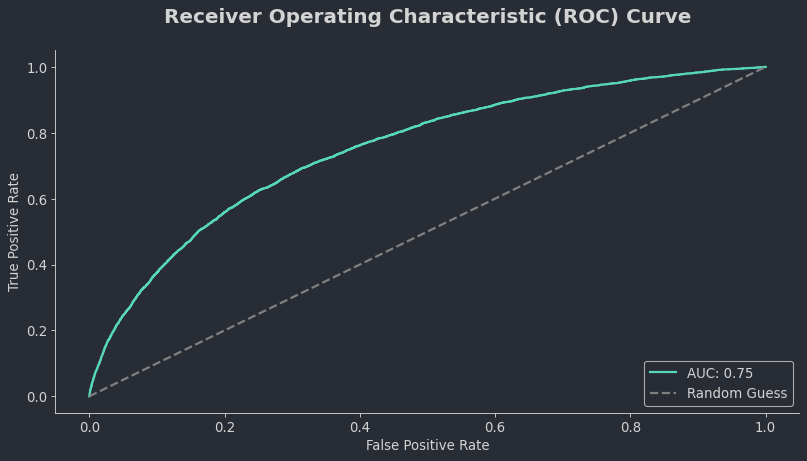

In [214]:
plt.plot(fpr, tpr, label = f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

## Logistic Regression with PCA

In [215]:
pca = PCA(n_components = X_train_scaled[0].size)
pca.fit(X_train_scaled)
explained_variance_ratios = pca.explained_variance_ratio_
cum_evr = explained_variance_ratios.cumsum()

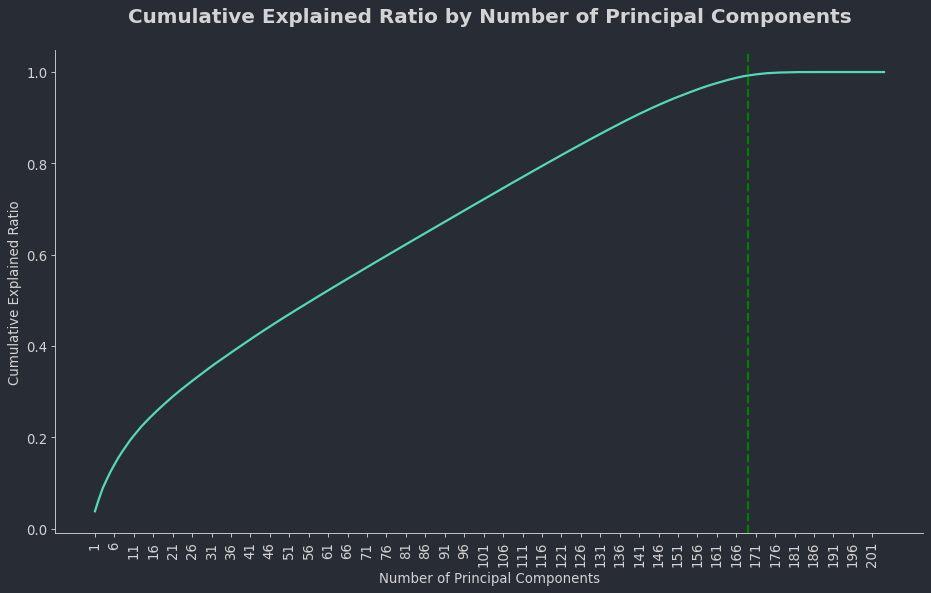

In [216]:
fig = plt.figure(figsize = (14,8))
ax = fig.add_subplot(111)

ax.plot(cum_evr)
ax.set_xticks(np.arange(0, X_train_scaled[0].size, 5))
ax.set_xticklabels(np.arange(0, X_train_scaled[0].size, 5) + 1, rotation = 90)

ax.set_xlabel('Number of Principal Components')
ax.set_ylabel('Cumulative Explained Ratio')
ax.set_title('Cumulative Explained Ratio by Number of Principal Components')

#Vertical Line here at 11 really means 12 components
ax.axvline(168, linestyle = '--', color='green')

plt.show()

In [217]:
"{:.2%}".format(cum_evr[168]) #note that 168 is the 169th component

'99.24%'

In [218]:
pca = PCA(n_components = 169)
pca.fit(X_train_scaled)

PCA(n_components=169)

In [219]:
X_train_PCA = pca.transform(X_train_scaled)
X_test_PCA = pca.transform(X_test_scaled)

In [220]:
#really no need to reassign y_train and y_test here b/c the seed is the same
X_train_PCA_resampled, y_train_PCA_resampled = RandomOverSampler(random_state=seed).fit_resample(X_train_PCA, y_train)

In [221]:
optimized_C = 10
optimized_penalty = 'l2'

logistic_regression_model = LogisticRegression(max_iter = 10_000, C = optimized_C, penalty = optimized_penalty)
logistic_regression_model.fit(X_train_PCA_resampled, y_train_PCA_resampled)

LogisticRegression(C=10, max_iter=10000)

In [222]:
y_pred = logistic_regression_model.predict(X_test_PCA)

In [224]:
# get the confusion matrix

confusion_matrix(y_test, y_pred)

array([[38189, 18014],
       [ 1559,  3405]], dtype=int64)

In [225]:
#PCA resulted in a slight dip in accuracy
# get the accuracy, precision, recall and F1 scores

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2%}')
print(f'Precision: {precision:.2%}')
print(f'Recall: {recall:.2%}')
print(f'F1: {f1:.2%}')

Accuracy: 68.00%
Precision: 15.90%
Recall: 68.59%
F1: 25.81%


In [226]:
# plot the ROC curve

y_proba = logistic_regression_model.predict_proba(X_test_PCA)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
print(auc)

0.7457844730372831


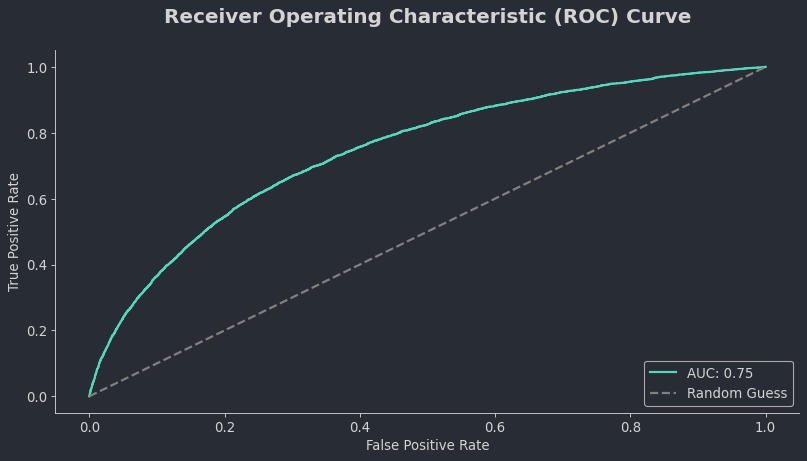

In [227]:
plt.plot(fpr, tpr, label = f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

# Grid Search

In [239]:
# create a pipeline

pipeline = Pipeline([
#    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter = 1000))
])

In [240]:
# define the hyperparameter grid

# regularization strength
C_vals = [0.001, 0.01, 0.1, 1, 10, 100]

param_grid = {
#    'scaler__with_mean' : [True, False],
#    'scaler__with_std'  : [True, False],
    'classifier__C' : C_vals,
#    'classifier__l1_ratio' : [0.1, 0.3, 0.5, 0.7, 0.9],   # this is the mix between L1 and L2 regularization
    'classifier__penalty' : ['l1', 'l2']
}

In [241]:
grid_search = GridSearchCV(pipeline, param_grid, cv = 5, scoring = 'accuracy')

In [245]:
# fit the grid search to the data (takes about 15 minutes to run the grid search)
grid_search.fit(X_train_scaled_resampled, y_train_scaled_resampled)

c:\Users\paulh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
30 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\paulh\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\paulh\anaconda3\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "c:\Users\paulh\anaconda3\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\p

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'classifier__penalty': ['l1', 'l2']},
             scoring='accuracy')

In [246]:
best_params = grid_search.best_params_
best_params

{'classifier__C': 100, 'classifier__penalty': 'l2'}

In [247]:
best_model = grid_search.best_estimator_
best_model

Pipeline(steps=[('classifier', LogisticRegression(C=100, max_iter=1000))])

In [248]:
y_pred_optimzed = best_model.predict(X_test_scaled)

accuracy_optimized = best_model.score(X_test_scaled, y_test)
accuracy_optimized

0.691418575375611

Observations
* the grid search optimization improves accuracy *slightly*
* the AUC does not change

## Decision Trees

In [284]:
# create the decision tree classifier
clf_tree = DecisionTreeClassifier(random_state = 42, max_depth = 10,min_samples_split= 50)

# configure the parameter grid
#param_grid = {
#    'criterion' : ['gini', 'entropy'],
#    'max_depth' : [None, 10, 20, 30],
#  }

# create the grid search object
#grid_search = GridSearchCV(clf_tree, param_grid, scoring = 'accuracy')



In [285]:
# fit the model to the training data

#grid_search.fit(X_train_scaled_resampled, y_train_scaled_resampled)
# I don't think we have to use scaled data here but I guess it doesn't really matter

clf_tree.fit(X_train_scaled_resampled, y_train_scaled_resampled)
y_pred = clf_tree.predict(X_test_scaled)

In [268]:
accuracy = clf_tree.score(X_test_scaled, y_test)
print(f'The accuracy is: {accuracy:.2%}')

The accuracy is: 85.89%


In [286]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.68      0.80     56203
           1       0.15      0.63      0.24      4964

    accuracy                           0.68     61167
   macro avg       0.55      0.66      0.52     61167
weighted avg       0.89      0.68      0.75     61167



In [287]:
confusion_matrix(y_test, y_pred)


array([[38485, 17718],
       [ 1849,  3115]], dtype=int64)

In [288]:
# plot the ROC curve

y_proba = clf_tree.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
print(auc)

0.6991272844067341


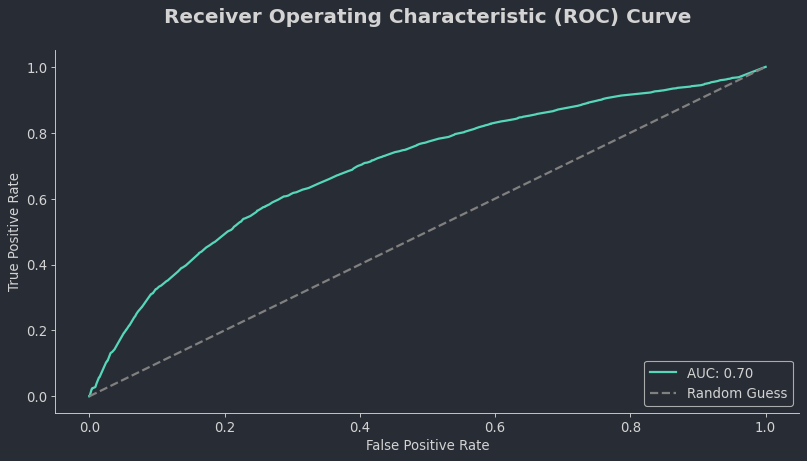

In [289]:

plt.plot(fpr, tpr, label = f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

## Random Forest

In [256]:
# create the random forest classifier
clf_random_forest = RandomForestClassifier(random_state = 42,max_depth = 10)

# configure the parameter grid
#param_grid = {
#    'criterion' : ['gini', 'entropy'],
#    'max_depth' : [None, 10, 20, 30],
#  }

# create the grid search object
#grid_search = GridSearchCV(clf_random_forest, param_grid, scoring = 'accuracy')

In [257]:
# fit the model to the training data

#grid_search.fit(X_train_scaled_resampled, y_train_scaled_resampled)

clf_random_forest.fit(X_train_scaled_resampled, y_train_scaled_resampled)
y_pred = clf_random_forest.predict(X_test_scaled)


In [258]:
accuracy = clf_random_forest.score(X_test_scaled, y_test)
print(f'The accuracy is: {accuracy:.2%}')

The accuracy is: 72.67%


In [259]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.74      0.83     56203
           1       0.17      0.62      0.27      4964

    accuracy                           0.73     61167
   macro avg       0.56      0.68      0.55     61167
weighted avg       0.89      0.73      0.79     61167



In [260]:
confusion_matrix(y_test, y_pred)

array([[41387, 14816],
       [ 1901,  3063]], dtype=int64)

In [261]:
# plot the ROC curve

y_proba = clf_random_forest.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
print(auc)

0.7362285899180109


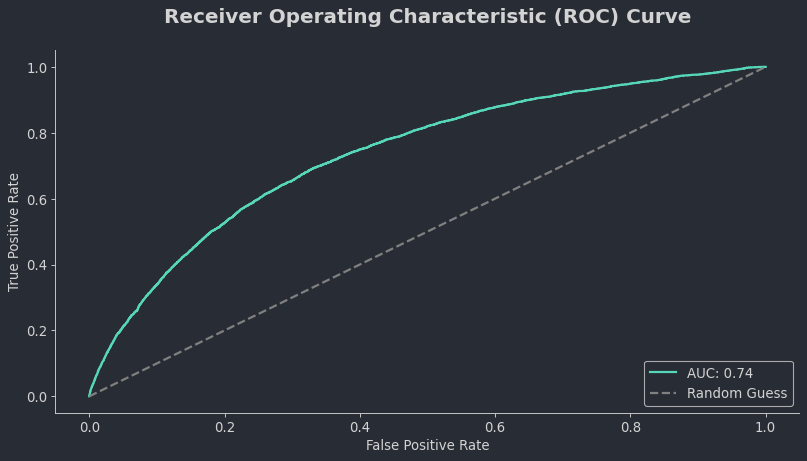

In [262]:
plt.plot(fpr, tpr, label = f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [166]:
#more memory cleanup
del clf_random_forest
del clf_tree

## Gradient Boosting

In [291]:
# create the gradient boost classifier
clf_gradient_boost = GradientBoostingClassifier(random_state = 42)

# configure the parameter grid
#param_grid = {
#    'criterion' : ['gini', 'entropy'],
#    'max_depth' : [None, 10, 20, 30],
#  }

# create the grid search object
#grid_search = GridSearchCV(clf_random_forest, param_grid, scoring = 'accuracy')

In [292]:
# fit the model to the training data

#grid_search.fit(X_train_scaled_resampled, y_train_scaled_resampled)

clf_gradient_boost.fit(X_train_scaled_resampled, y_train_scaled_resampled)
y_pred = clf_gradient_boost.predict(X_test_scaled)

In [293]:
accuracy = clf_gradient_boost.score(X_test_scaled, y_test)
print(f'The accuracy is: {accuracy:.2%}')

The accuracy is: 71.08%


In [294]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.72      0.82     56203
           1       0.17      0.66      0.27      4964

    accuracy                           0.71     61167
   macro avg       0.56      0.69      0.54     61167
weighted avg       0.90      0.71      0.78     61167



In [295]:
confusion_matrix(y_test, y_pred)

array([[40209, 15994],
       [ 1693,  3271]], dtype=int64)

In [296]:
# plot the ROC curve

y_proba = clf_gradient_boost.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
print(auc)

0.7531583807879125


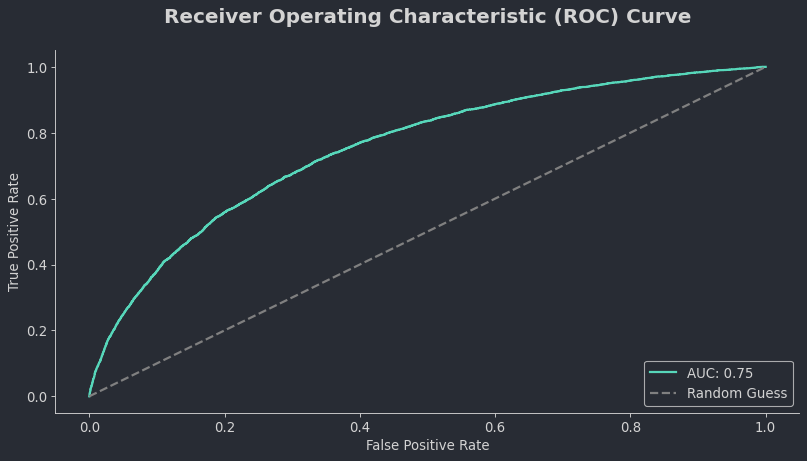

In [297]:
plt.plot(fpr, tpr, label = f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

## XG Boost

In [300]:
# create the gradient boost classifier
clf_xg_boost = XGBClassifier(random_state = 42)

# configure the parameter grid
#param_grid = {
#    'criterion' : ['gini', 'entropy'],
#    'max_depth' : [None, 10, 20, 30],
#  }

# create the grid search object
#grid_search = GridSearchCV(clf_random_forest, param_grid, scoring = 'accuracy')

In [301]:
# fit the model to the training data

#grid_search.fit(X_train_scaled_resampled, y_train_scaled_resampled)

clf_xg_boost.fit(X_train_scaled_resampled, y_train_scaled_resampled)
y_pred = clf_xg_boost.predict(X_test_scaled)

In [302]:
accuracy = clf_xg_boost.score(X_test_scaled, y_test)
print(f'The accuracy is: {accuracy:.2%}')

The accuracy is: 77.39%


In [303]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.79      0.87     56203
           1       0.19      0.54      0.28      4964

    accuracy                           0.77     61167
   macro avg       0.57      0.67      0.57     61167
weighted avg       0.89      0.77      0.82     61167



In [304]:
confusion_matrix(y_test, y_pred)


array([[44666, 11537],
       [ 2290,  2674]], dtype=int64)

In [318]:
# plot the ROC curve

y_proba = clf_xg_boost.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
print(auc)


0.733491506621638


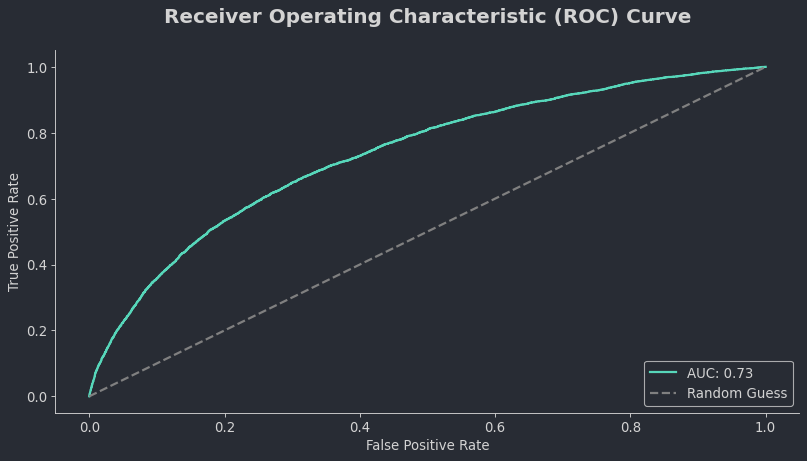

In [319]:
plt.plot(fpr, tpr, label = f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

## Cross Validation

In [182]:
from sklearn.model_selection import cross_val_score

In [183]:
scores = cross_val_score(XGBClassifier(random_state = 42), X_train_scaled_resampled, y_train_scaled_resampled, cv=5, scoring='accuracy')

In [184]:
scores

array([0.76918117, 0.76842527, 0.76576847, 0.77067932, 0.76824483])

In [187]:
scores = cross_val_score(XGBClassifier(random_state = 42), X_train, y_train, cv=5, scoring='accuracy')

In [188]:
scores

array([0.91889075, 0.91876814, 0.91856212, 0.91944087, 0.91925694])

In [194]:
scores

array([0.91889075, 0.91876814, 0.91856212, 0.91944087, 0.91925694])

In [195]:
clf_xg_boost = XGBClassifier(random_state = 42)
clf_xg_boost.fit(X_train_scaled, y_train)
y_pred = clf_xg_boost.predict(X_test)

c:\Users\paulh\anaconda3\lib\site-packages\xgboost\core.py:160: UserWarning: [19:32:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0750514818a16474a-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


In [196]:
accuracy = clf_xg_boost.score(X_test_scaled, y_test)
print(f'The accuracy is: {accuracy:.2%}')

The accuracy is: 57.95%


In [202]:
X_train_resampled, y_train_resampled = RandomOverSampler(random_state=seed).fit_resample(X_train, y_train)

In [299]:
X_test_scaled_resampled

NameError: name 'X_test_scaled_resampled' is not defined

In [200]:
X_train_resampled

,sk_id_curr,cnt_children,amt_income_total,amt_credit,amt_annuity,amt_goods_price,region_population_relative,days_birth,days_employed,days_registration,...,organization_type_Transport: type 2,organization_type_Transport: type 3,organization_type_Transport: type 4,organization_type_University,organization_type_XNA,fondkapremont_mode_missing,fondkapremont_mode_not specified,fondkapremont_mode_org spec account,fondkapremont_mode_reg oper account,fondkapremont_mode_reg oper spec account
0,232026,0,81000.0,942300.0,30528.0,675000.0,0.006008,-17663,-237,-488.0,...,False,False,False,False,False,True,False,False,False,False
1,367885,0,112500.0,314100.0,13437.0,225000.0,0.020246,-24088,365243,-10075.0,...,False,False,False,False,True,False,False,False,True,False
2,252536,1,81000.0,894766.5,29569.5,679500.0,0.008019,-14657,-845,-9285.0,...,False,False,False,False,False,True,False,False,False,False
3,432885,2,56250.0,319981.5,16465.5,243000.0,0.008068,-13965,-92,-153.0,...,False,False,False,False,False,True,False,False,False,False
4,266655,0,90000.0,71109.0,5746.5,54000.0,0.009334,-19417,-1672,-6784.0,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449783,136610,0,146250.0,497520.0,31923.0,450000.0,0.020246,-24348,365243,-1129.0,...,False,False,False,False,True,True,False,False,False,False
449784,123900,2,112500.0,454500.0,24786.0,454500.0,0.028663,-14497,-576,-8603.0,...,False,False,False,False,False,False,False,False,True,False
449785,125283,0,58500.0,401386.5,21901.5,346500.0,0.010966,-21410,365243,-10213.0,...,False,False,False,False,True,True,False,False,False,False
449786,163359,0,180000.0,310671.0,15241.5,256500.0,0.006305,-13038,-699,-1154.0,...,False,False,False,False,False,True,False,False,False,False


In [ ]:

X_test_resampled = RandomOverSampler(random_state=seed).fit_resample(X_test, y_test)[0]

In [ ]:
X_train_resampled

## XGBoost with PCA

## XGBoost with Bagging

In [298]:
from sklearn.ensemble import BaggingClassifier

In [325]:
clf_xg_boost = XGBClassifier(random_state = 42,
                             n_estimators = 1000,
                             #max_depth = 10,
                             #learning_rate = 0.10,
                             #reg_lambda = 1
                             )

In [326]:
clf_xg_boost.fit(X_train_scaled_resampled, y_train_scaled_resampled)
y_pred = clf_xg_boost.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test, y_pred))
# plot the ROC curve

y_proba = clf_xg_boost.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
print(auc)


In [323]:
print(classification_report(y_test, y_pred))
# plot the ROC curve

y_proba = clf_xg_boost.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc = roc_auc_score(y_test, y_proba)
print(auc)


              precision    recall  f1-score   support

           0       0.92      0.99      0.96     56203
           1       0.35      0.05      0.09      4964

    accuracy                           0.92     61167
   macro avg       0.64      0.52      0.52     61167
weighted avg       0.88      0.92      0.89     61167

0.6724484899715222


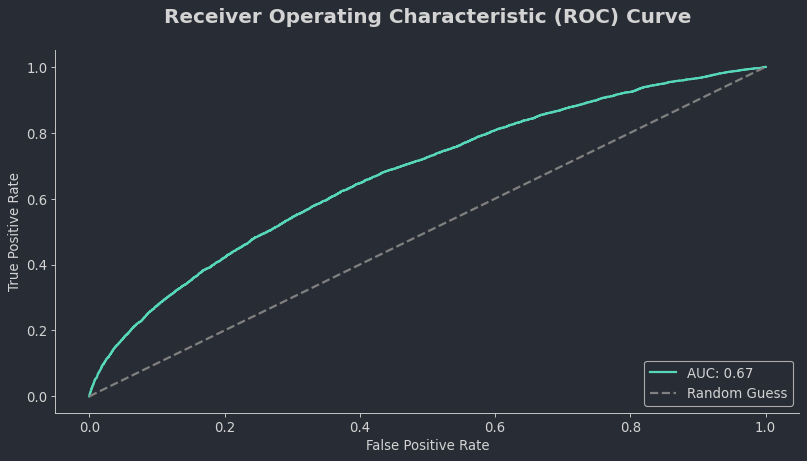

In [324]:
plt.plot(fpr, tpr, label = f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle = '--', color = 'gray', label = 'Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
bag = BaggingClassifier(base_estimator = clf_xg_boost, 
                        n_estimators = 500, 
                        random_state = 42,
                        max_samples = 1.0, 
                        max_features = 1.0, 
                        bootstrap = True, 
                        bootstrap_features = False, 
                        n_jobs = -1)

# Challenges and Obstacles

TO DO

* grid search with 5-fold cross-validation takes a long time!

# Potential Next Steps / Future Direction

TO DO

could do AutoML